In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow as tf
from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

## Utility Functions

In [2]:
def load_dataset():
    train_dataset = h5py.File('datasets/train_signs.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) 

    test_dataset = h5py.File('datasets/test_signs.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) 

    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes



In [3]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    
    m = X.shape[0]                 
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size) 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [4]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

## Data Handling

In [5]:
# Loading the data (signs)
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

y = 2


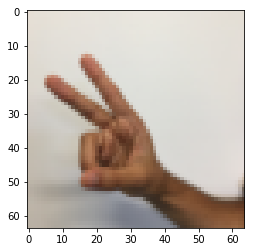

In [6]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

In [7]:
X_train = X_train_orig/255.
X_test = X_test_orig/255.
Y_train = convert_to_one_hot(Y_train_orig, 6).T
Y_test = convert_to_one_hot(Y_test_orig, 6).T
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


## Building NN using Tensorflow 1

In [8]:


def create_placeholders(n_H0, n_W0, n_C0, n_y):
   
    X = tf.placeholder(dtype = "float", shape = (None,n_H0,n_W0,n_C0))
    Y = tf.placeholder(dtype = "float", shape = (None,n_y))
    
    return X, Y

In [9]:


def initialize_parameters(filter1,filter2,class_3d,n_filter1,n_filter2):
    
    tf.set_random_seed(1)  
    
    W1 = tf.get_variable("W1",[filter1,filter1,class_3d,n_filter1],initializer= tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2",[filter2,filter2,n_filter1,n_filter2],initializer= tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [10]:


def forward_propagation(X, parameters):
   
    
    
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1,strides=[1,1,1,1],padding = "SAME")
    
    # RELU
    A1 = tf.nn.relu(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1],strides = [1,8,8,1],padding="SAME")
    
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2,strides = [1,1,1,1],padding= "SAME")
    
    # RELU
    A2 = tf.nn.relu(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1],strides = [1,4,4,1],padding = "SAME")
    
    # FLATTEN
    F = tf.contrib.layers.flatten(P2)
    
    # 6 neurons in output layer
    Z3 = tf.contrib.layers.fully_connected(F,6,activation_fn=None)

    return Z3

In [11]:
 

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y,logits =Z3))
    
    return cost

In [14]:


def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.01,
          num_epochs = 100, minibatch_size = 128, print_cost = True):
   
    ops.reset_default_graph()                         
    tf.set_random_seed(1)                             
    seed = 3                                          
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        
    
    X, Y =create_placeholders(n_H0,n_W0,n_C0,n_y)


    # Initialize parameters
    parameters = initialize_parameters(4,2,n_C0,16,20)
    Z3 = forward_propagation(X,parameters)
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
     
    with tf.Session() as sess:
        
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                
                _ , temp_cost = sess.run([optimizer,cost],feed_dict= {X:minibatch_X,Y:minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            if print_cost == True and epoch % 10 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("\n\nTrain Accuracy:", train_accuracy)
        print("\nTest Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 2.030775
Cost after epoch 10: 1.134097
Cost after epoch 20: 0.645695
Cost after epoch 30: 0.442519
Cost after epoch 40: 0.311627
Cost after epoch 50: 0.218095
Cost after epoch 60: 0.229883
Cost after epoch 70: 0.147782
Cost after epoch 80: 0.167822
Cost after epoch 90: 0.098118


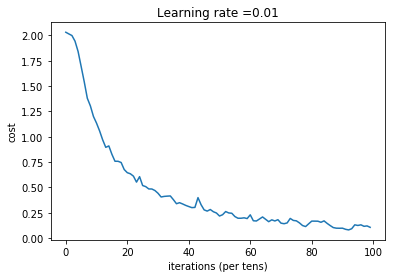

Tensor("Mean_1:0", shape=(), dtype=float32)


Train Accuracy: 0.987037

Test Accuracy: 0.85


In [15]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)